In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetMobile,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = NASNetMobile(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 1056)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min


[CV] .............. C=0.01, gamma=1e-07, score=0.505718, total=  53.7s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  53.9s
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  54.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  53.9s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total=  54.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505718, total=  53.9s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505718, total=  54.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.6min


[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  53.7s
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  54.0s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  53.9s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  54.1s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  54.3s
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total=  54.1s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505089, total=  54.1s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min


[CV] ............... C=0.01, gamma=0.01, score=0.864041, total=  37.9s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.868957, total=  37.7s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.874046, total=  38.1s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.881679, total=  38.5s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.898219, total=  38.6s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.820839, total=  50.3s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.832061, total=  51.4s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min


[CV] ................ C=0.01, gamma=1.0, score=0.505718, total=  53.8s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=  53.6s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  55.0s
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  54.6s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  55.0s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  55.2s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505718, total=  53.2s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  4.0min


[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total=  52.2s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total=  52.6s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total=  51.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total=  51.5s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505718, total=  51.6s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  50.9s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  52.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  4.9min


[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total=  54.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505718, total=  54.1s
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total=  54.7s
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total=  54.8s
[CV] C=0.1, gamma=1.0 ................................................
[CV] C=0.1, gamma=1.0 ................................................
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total=  54.2s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total=  55.1s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.505089, total=  54.7s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  5.2min


[CV] ............... C=0.1, gamma=0.001, score=0.885496, total=  26.6s
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.865140, total=  46.8s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.903308, total=  21.7s
[CV] .............. C=0.1, gamma=0.0001, score=0.851145, total=  46.6s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.852417, total=  46.6s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.743003, total=  48.5s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.779898, total=  48.8s
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.6min


[CV] ................. C=0.1, gamma=1.0, score=0.508906, total=  54.6s
[CV] ................. C=0.1, gamma=1.0, score=0.511450, total=  53.7s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=  53.4s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=  53.9s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  50.2s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  50.3s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  50.9s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  7.3min


[CV] ............... C=1.0, gamma=0.001, score=0.921120, total=  17.5s
[CV] C=1.0, gamma=0.1 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.874206, total=  26.4s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.870229, total=  26.4s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.886768, total=  26.3s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.893130, total=  26.6s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.909669, total=  27.1s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.949109, total=  14.9s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  8.1min


[CV] ............... C=1.0, gamma=1e-06, score=0.505089, total=  54.7s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.505089, total=  54.6s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.883100, total=  45.4s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.898219, total=  51.1s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.889313, total=  45.4s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.912214, total=  45.8s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.871501, total=  45.2s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  9.3min


[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total=  47.9s
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.923761, total=  15.9s
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.914758, total=  15.5s
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.935115, total=  16.2s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total=  54.2s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.944091, total=  11.8s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total=  53.9s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  9.8min


[CV] .............. C=10.0, gamma=1e-06, score=0.826972, total=  44.2s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.949109, total=  12.7s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.865140, total=  44.3s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.851145, total=  43.8s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.942748, total=  12.3s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.935115, total=  11.8s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=0.01, score=0.966963, total=  15.8s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 11.3min


[CV] ............... C=10.0, gamma=10.0, score=0.555980, total=  53.1s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.505718, total=  53.8s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.604828, total=  53.4s
[CV] ............. C=100.0, gamma=1e-08, score=0.505089, total=  52.7s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.614504, total=  53.6s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.624682, total=  54.3s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.550191, total=  53.6s
[CV] C=100.0, gamma=0.001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 11.8min


[CV] ............ C=100.0, gamma=0.0001, score=0.938931, total=  13.7s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.919847, total=  18.2s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.932570, total=  18.3s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.935115, total=  19.0s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.874206, total=  27.2s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.870229, total=  26.8s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=0.001, score=0.940204, total=  11.8s
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 13.1min


[CV] ............... C=100.0, gamma=0.1, score=0.876590, total=  48.9s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.893130, total=  23.1s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.895674, total=  50.2s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.907125, total=  50.4s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.604828, total=  52.2s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.614504, total=  52.1s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.629771, total=  52.0s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 14.0min remaining:   47.3s


[CV] ............. C=1000.0, gamma=0.01, score=0.965693, total=  15.4s
[CV] .............. C=1000.0, gamma=0.1, score=0.916031, total=  33.2s
[CV] .............. C=1000.0, gamma=0.1, score=0.886912, total=  33.4s
[CV] .............. C=1000.0, gamma=1.0, score=0.629771, total=  33.7s
[CV] .............. C=1000.0, gamma=0.1, score=0.907125, total=  41.7s
[CV] ............. C=1000.0, gamma=10.0, score=0.563613, total=  31.6s
[CV] ............. C=1000.0, gamma=10.0, score=0.555980, total=  32.0s
[CV] ............. C=1000.0, gamma=10.0, score=0.548346, total=  37.4s
[CV] .............. C=1000.0, gamma=0.1, score=0.876590, total=  44.3s
[CV] .............. C=1000.0, gamma=0.1, score=0.895674, total=  44.7s
[CV] .............. C=1000.0, gamma=1.0, score=0.624682, total=  42.8s
[CV] .............. C=1000.0, gamma=1.0, score=0.614504, total=  42.3s
[CV] .............. C=1000.0, gamma=1.0, score=0.632316, total=  41.7s
[CV] .............. C=1000.0, gamma=1.0, score=0.604828, total=  42.9s
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([44.67785578, 44.04904532, 44.10388441, 44.69774055, 44.44493346,
        42.07774301, 30.87403111, 44.10025115, 42.72845111, 41.64342031,
        42.2079946 , 41.8556747 , 43.69193764, 43.47567244, 38.30963402,
        20.90495315, 17.08660874, 39.69071293, 42.52052512, 41.78934898,
        41.49973216, 40.19776058, 42.0158258 , 38.22719073, 21.52461281,
        13.93693633, 12.45460691, 38.9109478 , 44.10591335, 40.07605681,
        40.02884192, 42.34093862, 36.63819122, 21.42752075, 13.38640308,
         9.87369514, 12.11324878, 41.16594872, 43.76761804, 44.01334853,
        43.2441968 , 37.77796912, 21.98098435, 14.71465158, 11.20802989,
        10.01410327, 12.57217946, 41.54137168, 42.96362743, 42.39395556,
        39.07223382, 20.21662288, 13.82865577, 11.0014329 , 10.0250814 ,
         9.52285848, 12.4814817 , 34.3618937 , 34.68214736, 30.74281158]),
 'mean_score_time': array([ 9.53775783, 10.06225457, 10.01356854,  9.54636302,  9.75291824,
         9.23

In [11]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-06},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-05},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.84431, std: 0.01561, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.87738, std: 0.01194, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.1},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-06},
 mean: 0.50521, std: 0.00025, params: {'C': 0.1, 'gamma': 1e-05},
 mean: 0.84381, std: 0.01610, params: {'C': 0.1, 'gamma': 0.0001},
 mea

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.01} - score: 0.9624


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


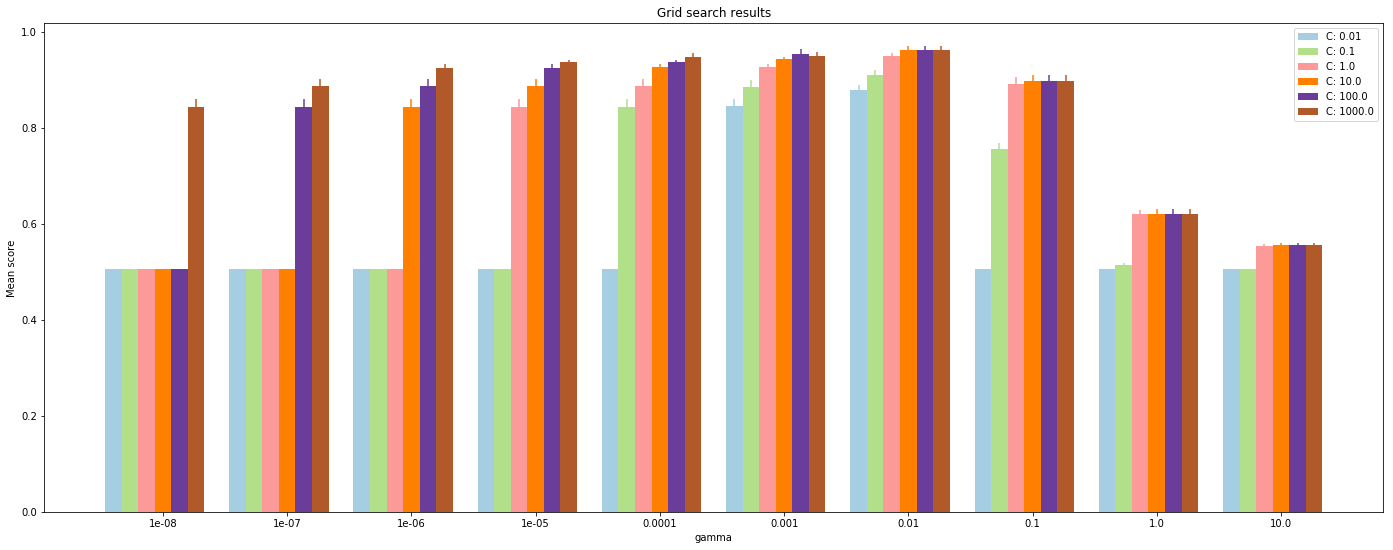

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()